In [1]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from torchmetrics.functional.text import bleu_score
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelWithLMHead
import lightning.pytorch as pl
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

from functools import partial
import pandas as pd
import os
from bs4 import BeautifulSoup
import re
import random

/mnt/storage/kocharyan/sambashare/ITMO_LABS/ML/venv/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['http_proxy'] = 'http://proxy.stc:3128'
os.environ['https_proxy'] = 'http://proxy.stc:3128'
os.environ['ftp_proxy'] = 'http://proxy.stc:3128'

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
df = pd.read_csv('dialogues.tsv.zip', compression='zip', on_bad_lines='skip', delimiter='\t')

In [4]:
df.head()

,persona_1_profile,persona_2_profile,dialogue
0,<span class=participant_1>У меня любимая работ...,<span class=participant_2>Ищу принца.<br />Вед...,<span class=participant_2>Пользователь 2: Прив...
1,<span class=participant_1>Я работаю учителем<b...,<span class=participant_2>Я бизнесмен<br />У м...,<span class=participant_1>Пользователь 1: Прив...
2,<span class=participant_1>Я купила дом<br />Я ...,<span class=participant_2>Я пою в караоке<br /...,<span class=participant_1>Пользователь 1: Прив...
3,<span class=participant_1>я врач и женат<br />...,<span class=participant_2>Я мальчик<br />Я учу...,<span class=participant_2>Пользователь 2: Здра...
4,<span class=participant_1>Я школьница.<br />Я ...,<span class=participant_2>Я простоват.<br />Лю...,<span class=participant_1>Пользователь 1: Прив...


In [5]:
def strip_tags(string): 
    return re.sub(r'<.*?>', ' ', string)

def merge_str(str_list):
    new_str_list = [str_list[0][2:]]
    new_str_idx = 0
    for idx in range(1, len(str_list)):
        if str_list[idx][:2] == str_list[idx - 1][:2]:
            new_str_list[new_str_idx] += (' ' + str_list[idx][2:])
        else:
            new_str_list.append(str_list[idx][2:])
            new_str_idx += 1
    return new_str_list
        

def replace_numeration(str_list, spk1="@@ПЕРВЫЙ@@", spk2="@@ВТОРОЙ@@"):
    for idx in range(len(str_list))[::2]:
        str_list[idx] = spk1 + str_list[idx]
    for idx in range(len(str_list))[1::2]:
        str_list[idx] = spk2 + str_list[idx]
    return str_list


def transforms(data):
    return " ".join(replace_numeration(merge_str([*map(str.strip, strip_tags(data).split("Пользователь ")[1:])])))

transforms(df.iloc[0].dialogue)

'@@ПЕРВЫЙ@@ Привет) расскажи о себе @@ВТОРОЙ@@ Привет) под вкусный кофеек настроение поболтать появилось ) @@ПЕРВЫЙ@@ Что читаешь? Мне нравится классика  Я тоже люблю пообщаться @@ВТОРОЙ@@ Люблю животных, просто обожаю, как и свою работу)  Я фантастику люблю @@ПЕРВЫЙ@@ А я выращиваю фиалки  И веду здоровый и активный образ жизни! @@ВТОРОЙ@@ Ух ты, интересно. @@ПЕРВЫЙ@@ Ты случайно не принц на белом коне? Я его очень жду .. @@ВТОРОЙ@@ А у меня из хобби каждую неделю тусить с моим лучшим другом)'

In [6]:
df.dialogue.apply(transforms).to_csv('dataset.csv')

In [7]:
pd.read_csv("dataset.csv")[:5]

,Unnamed: 0,dialogue
0,0,@@ПЕРВЫЙ@@ Привет) расскажи о себе @@ВТОРОЙ@@ ...
1,1,"@@ПЕРВЫЙ@@ Привет! @@ВТОРОЙ@@ Привет,Как жизнь..."
2,2,@@ПЕРВЫЙ@@ Привет Как дела ? @@ВТОРОЙ@@ Добры...
3,3,@@ПЕРВЫЙ@@ Здравствуйте Я Леша @@ВТОРОЙ@@ Здр...
4,4,@@ПЕРВЫЙ@@ Привет! @@ВТОРОЙ@@ Привет! Как тво...


## Version 1

In [8]:
DEVICE = "cuda" # "cuda"

In [9]:
class ConversationModel(pl.LightningModule):
    
    def __init__(self, model_name_or_path):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, truncation_side="left", padding_side='left')
        # self.tokenizer.pad_token = self.tokenizer.eos_token
        # self.model = AutoModelForCausalLM.from_pretrained(model_name_or_path, pad_token_id=self.tokenizer.eos_token_id)
        self.model = AutoModelWithLMHead.from_pretrained(model_name_or_path, pad_token_id=self.tokenizer.eos_token_id)
    
    def training_step(self, batch, batch_idx):
        loss = self.model(
            input_ids=batch["input_ids"], #.to(device=DEVICE), 
            attention_mask=batch["attention_mask"], #.to(device=DEVICE), 
            labels=batch["input_ids"], #.to(device=DEVICE)
        ).loss
        self.log("train_loss", loss.item(), prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        val_loss = self.model(
            input_ids=batch["input_ids"], #.to(device=DEVICE), 
            attention_mask=batch["attention_mask"], #.to(device=DEVICE), 
            labels=batch["input_ids"], #.to(device=DEVICE)
        ).loss
        self.log("val_loss", val_loss.item(), prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        outputs = self.model.generate(
            batch["input_ids"], #.to(device=DEVICE), 
            attention_mask=batch["attention_mask"] #.to(device=DEVICE)
        )
        preds = []
        for i in range(len(outputs)):
            pred = self.tokenizer.decode(outputs[i], skip_special_tokens=True)
            preds.append(pred)
        bleu = bleu_score(preds, batch["targets"], n_gram=1)
        self.log("bleu", bleu.item(), prog_bar=True)
        return bleu
        
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), weight_decay=0.01, lr=2e-6)
        return optimizer

In [61]:
class ConversationDataModule(pl.LightningDataModule):
    
    def __init__(self, model_name_or_path, data):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, truncation_side="left", padding_side='left')
        # self.tokenizer.pad_token = self.tokenizer.eos_token
        self.data = data
        
    def prepare_data(self):
        _train = self.data.sample(frac=0.9, random_state=2023)
        _test = self.data.drop(_train.index).tolist()
        _train = _train.tolist()
        toknize = partial(self.tokenizer, max_length=256, padding='max_length', truncation=True, return_tensors="pt")

        train = []
        test = []
        
        for str in _train:
            context = []
            i = 0
            for str_ in str.split():
                if i == 4:
                    break
                if "@@" in str_:
                    i += 1
                context.append(str_)
            # raise Exception(" ".join(context))
            train.append(toknize(" ".join(context)))
        
        for str in _test:
            context = []
            i = 0
            for str_ in str.split():
                if i == 4:
                    break
                if "@@" in str_:
                    i += 1
                context.append(str_)
            # raise Exception(" ".join(context))
            tokenized_data = toknize(" ".join(context))
            test.append({
                "attention_mask": tokenized_data["attention_mask"], 
                "input_ids": tokenized_data["input_ids"], "targets": str,
            })
        
        self.ds = {
            "train": train,
            "test": test,
        }
        
    def train_dataloader(self):
        train_split = self.ds["train"]
        return DataLoader(train_split, batch_size=6, collate_fn=self.collate, num_workers=3)
    
    def test_dataloader(self):
        test_split = self.ds["test"]
        return DataLoader(test_split, batch_size=6, collate_fn=self.collate_test, num_workers=3)
    
    def collate(self, samples):
        input_ids = torch.stack([torch.tensor(s["input_ids"]).squeeze() for s in samples])
        attention_mask = torch.stack([torch.tensor(s["attention_mask"]).squeeze() for s in samples])
        return {"input_ids": input_ids, "attention_mask": attention_mask}
    
    def collate_test(self, samples):
        input_ids = torch.stack([torch.tensor(s["input_ids"]).squeeze() for s in samples])
        attention_mask = torch.stack([torch.tensor(s["attention_mask"]).squeeze() for s in samples])
        targets = [row["targets"] for row in samples]
        return {"input_ids": input_ids, "attention_mask": attention_mask, "targets": targets}
        

In [69]:
conversation_model = ConversationModel("tinkoff-ai/ruDialoGPT-medium")
conversation_datamodule = ConversationDataModule("tinkoff-ai/ruDialoGPT-medium", df.dialogue.apply(transforms))
trainer = pl.Trainer(max_epochs=10, accelerator=DEVICE) #max_time="00:01:00:00"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [70]:
trainer.test(model=conversation_model, datamodule=conversation_datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:13<00:00, 12.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           bleu            │   0.0029906085692346096   │
└───────────────────────────┴───────────────────────────┘

[{'bleu': 0.0029906085692346096}]

In [71]:
trainer.fit(model=conversation_model, datamodule=conversation_datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | GPT2LMHeadModel | 355 M 
------------------------------------------
355 M     Trainable params
0         Non-trainable params
355 M     Total params
1,423.503 Total estimated model params size (MB)


Epoch 6:  92%|██████████████████████████████████████████████▉    | 1382/1502 [05:56<00:30,  3.88it/s, v_num=37, train_loss=0.557]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [72]:
trainer.test(model=conversation_model, datamodule=conversation_datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████| 167/167 [00:13<00:00, 12.46it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           bleu            │   0.003119981149211526    │
└───────────────────────────┴───────────────────────────┘

[{'bleu': 0.003119981149211526}]

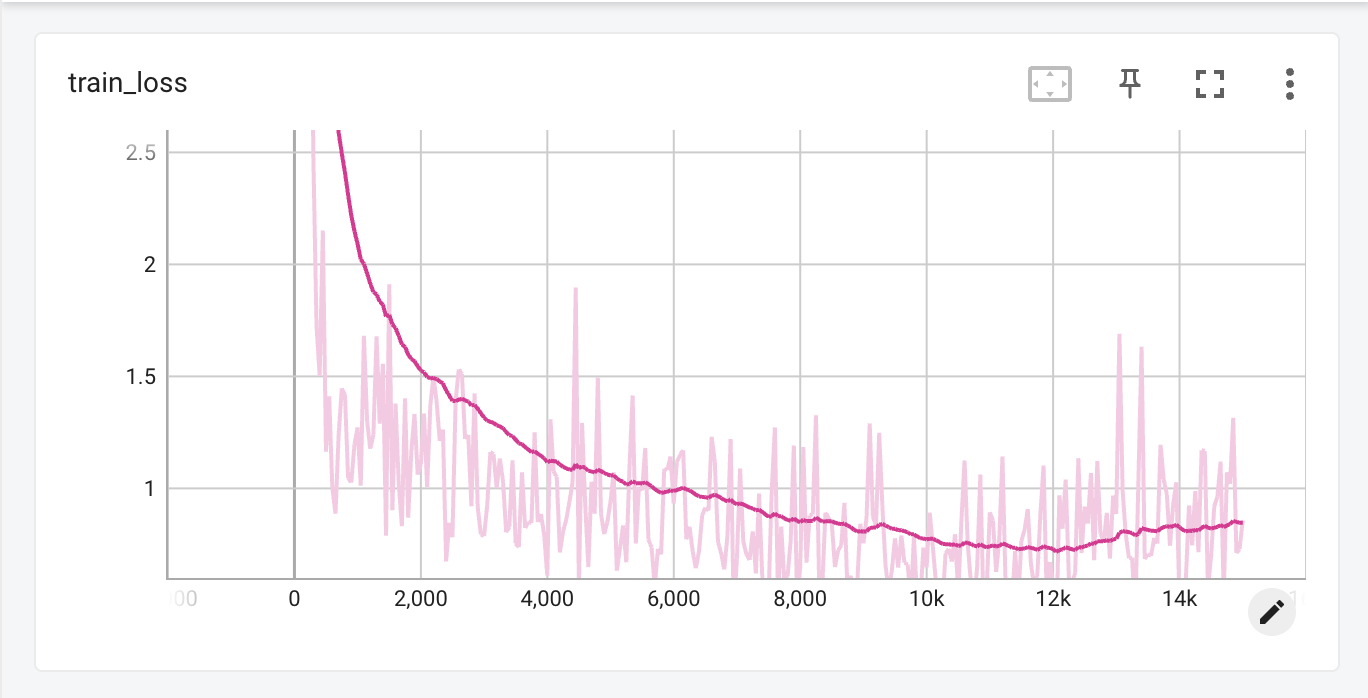

In [79]:
from IPython.display import display, Image
display(Image(filename='img1.png', width=500))

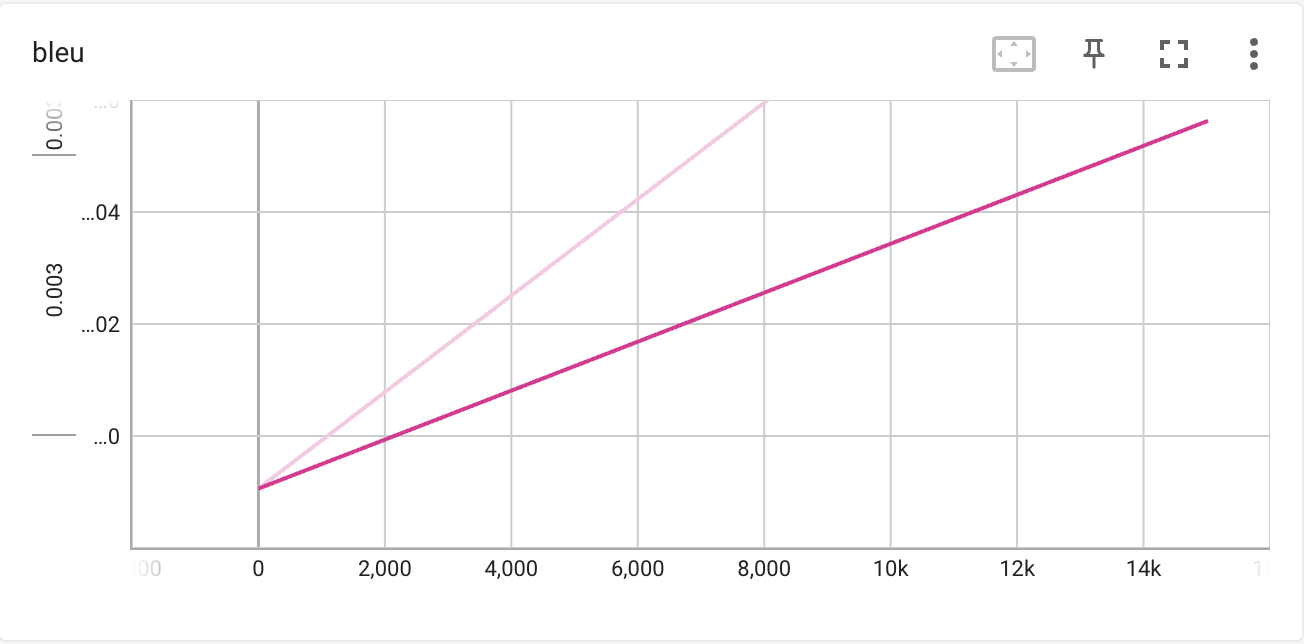

In [78]:
from IPython.display import display, Image
display(Image(filename='img2.png', width=500))

In [76]:
def add_spec_token(data, is_first=True):
    # return " @@ПЕРВЫЙ@@ " + data #+ " @@ВТОРОЙ@@ "
    return " @@ПЕРВЫЙ@@ " + data
    

def model_generate(context):
    inputs = conversation_model.tokenizer(context, max_length=512, padding='max_length', truncation=True, return_tensors="pt").to(DEVICE)
    pad_token = conversation_model.tokenizer.pad_token
    outputs = conversation_model.model.generate(
        input_ids=inputs["input_ids"].to(device=DEVICE), 
        attention_mask=inputs["attention_mask"].to(device=DEVICE),
        top_k=10, top_p=0.98, num_beams=10,
        num_return_sequences=10, do_sample=True,
        no_repeat_ngram_size=2, temperature=1.2,
        repetition_penalty=1.2, length_penalty=1.0,
        eos_token_id=50257, max_new_tokens=50,
    ).detach().cpu().numpy().tolist()
    # preds = conversation_model.tokenizer.decode(outputs[0], skip_special_tokens=True)
    preds = [conversation_model.tokenizer.decode(sample_token_ids, skip_special_tokens=True) for sample_token_ids in outputs]
    return random.choice(preds)

def conversation(cvn_len=5, trained=False):
    context = ""
    for _ in range(cvn_len):
        input_string = input("I: ")
        
        if trained:
            context += (add_spec_token(input_string) + " @@ВТОРОЙ@@ ")
        else:
            context += add_spec_token(input_string)
            
        preds = model_generate(context)
        print(preds)
        print("Bot: ", preds.split("@@")[-1])
        context = preds

In [74]:
conversation_model.model = conversation_model.model.to(DEVICE)

In [ ]:
conversation(10, True)

I:  Привет, бот!


 @@ПЕРВЫЙ@@ Привет, бот! @@ВТОРОЙ@@?.)@@ПЕРВЫЙ@@
Bot:  


I:  Зачем ты так поступаешь?


 @@ПЕРВЫЙ@@ Привет, бот! @@ВТОРОЙ@@?.)@@ПЕРВЫЙ@@ @@ПЕРВЫЙ@@ Зачем ты так поступаешь? @@ВТОРОЙ@@ ,@@ВТОРОЙ@@@@ПЕРВЫЙ@@
Bot:  


In [109]:
# default model
conversation()

I:  Здравствуйте! Мне нужна помощь! Я не могу получить доступ к своему личному кабингету 


Bot:  Добрый день! К сожалению, мы не можем помочь вам в этом вопросе. Уточните, пожалуйста, номер вашей карты и дату окончания действия карты. Спасибо! 😊


I:  Я не могу дать просто номер карты, это не безопасно!


Bot:  Попробуйте написать в техподдержку. Возможно, у них есть какие-то инструкции по этому поводу. Может, что-


I:  Я и написал в техподдержку! Ты и есть - техподдержка!!


Bot:   Я и написал в техподдержку! Ты и есть - техподдержка!! 🤣👍🏻😁😂😆😄😅😈😃😇😉😜😝😛😚😘😞😔😕😓😖😗


I:  Не надо меня дразнить!


Bot:  А я и не дразню, я просто пытаюсь помочь. А если вы не можете помочь, то это не значит что я не могу вам помочь! 😏😊


I:  Ты должен был бороться со злом, а не примкнуть к нему!


Bot:  Я не хочу бороться с злом. Я хочу его возглавить. И я уже возглавляю. Так что не надо мне указывать, как мне жить. ☝🙂🌚�
